In [ ]:
import sys

In [ ]:
device = 'cuda'

In [ ]:
from google.colab import files
files.upload()

Saving test.tsv.zip to test.tsv.zip
Saving train.tsv.zip to train.tsv.zip


{'test.tsv.zip': b'PK\x03\x04\x14\x00\x00\x00\x08\x00\x86)\xa3L\xfd\x165\x8b\xc6\xb7\x07\x00\xed`3\x00\x08\x00\x00\x00test.tsv\xe4\xbdI\x9b\xe3F\xb2-\xb8f\xff\n\xbcM\xe7&CM\xcc\xc0}\xab\x94TUR\r\xb7\xaaKzW\xef\xf6\xf7\x16B\x90`\x10J\x12`\x01`\x86\xa2~}\xbb\xd91\x00\x8e\x91\xe0\x14\x11\xaaZH\x198\xe7\x98\xb9\xc3\xcc1\xb8\xd3\xe1\xfe\xb7m\x1e\x15\xf1\xf7\xeb\xc5\x0fqZ\xc6\xe9\x8a\xfe\x04\xf6\x7f\x99\xae\xb7\xf4\xccE\xe0:\xee\xe2Sj$\x8a\xcf\xf7I\xa9T\xe5\xee\xc58\xec\xe2\xa8H\xd2\'\xe3\xf1X\x1a\xfb\xac ,\xcf\x8ee\x92\xc6F\xbc\xd9dyi|\x05\x17\xd6\xe5.\xe0\xc0\xae\x1c\xe0\xd0\xc1\xe1\x85\xce\xdcs\xada\xe6\x9d4\x83\xce\x9f\xd4A\x13\x0ci@\x85\xa0Zz\x7f\t\xb0*\xc3\x97\x9c\x0cT\xd3\xb7t\n\x90D\xaf%\x93\x10jq\xf1%.\xc8\x99\xcf\xa7\xeb-\xfe\x94\xac\xf7\x91\xca[a\xe4q\xb4S\x85\x95\xdb\xd8\xc8R\xfe\x83N\xbb\xdcF\xa5\xf1\xa10\x9e\x95\x9b\xad\xf1\x1c\x95+\x86\x93\xd4\xf8:Q\xc8:z1\xfe\x90\xe4;\xe3\xa3\x11\x19\x9bd\xb77\x1e\xe1\xa2(\xa3\xa7\xf8\xa1\xcc#U\xa3\xb5\xf1\xc7\xf8\x9f\xc6\xd7G\x15\x87\x1c~\x1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
!mv '/content/sampleSubmission.csv' '/content/drive/My Drive/LAB/kge_sentiment_analysis'
!mv '/content/test.tsv.zip' '/content/drive/My Drive/LAB/kge_sentiment_analysis'
!mv '/content/train.tsv.zip' '/content/drive/My Drive/LAB/kge_sentiment_analysis'
'''

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 890kB 4.6MB/s 
     |████████████████████████████████| 3.0MB 25.9MB/s 
     |████████████████████████████████| 1.1MB 27.8MB/s 
     |████████████████████████████████| 890kB 59.4MB/s 


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [ ]:
import fastai
import transformers
print('fastai version: %s' %(fastai.__version__))
print('transformers version: %s' %(transformers.__version__))

fastai version: 1.0.61
transformers version: 3.1.0


In [ ]:
for dirname, _, filenames in os.walk('/content/drive/My Drive/LAB/kge_sentiment_anlysis'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
DATA_ROOT = Path('/content/drive/My Drive/LAB/kge_sentiment_analysis')
train = pd.read_csv(DATA_ROOT / 'train.tsv.zip', sep="\t")
test = pd.read_csv(DATA_ROOT / 'test.tsv.zip', sep='\t')
print(train.shape, test.shape)
train.head()

(156060, 4) (66292, 3)


PhraseId  ...  Sentiment
0         1  ...          1
1         2  ...          2
2         3  ...          2
3         4  ...          2
4         5  ...          2

[5 rows x 4 columns]

In [ ]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [ ]:
# Parameters
seed = 42
use_fp16 = False
bs = 16
# model_type = 'roberta'
# pretrained_model_name = 'roberta-base'

# Model Selection
model_type = 'bert'
pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

# model_type = 'xlm'
# pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [ ]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

- BERT (from Google)
- XLNet (from Google/CMU)
- XLM (from Facebook)
- RoBERTa (from Facebook)
- DistilBERT (from HuggingFace)


In [ ]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu vars

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True # speed up with gpu
        torch.backends.cudnn.benchmark = False


In [ ]:
seed_all(seed)

#### Data pre-processing

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type='bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs):
        return self
    
    def tokenizer(self, t:str) -> List[str]:
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] + [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

- bert:       [CLS] + tokens + [SEP] + padding

- roberta:    [CLS] + prefix_space + tokens + [SEP] + padding

- distilbert: [CLS] + tokens + [SEP] + padding

- xlm:        [CLS] + tokens + [SEP] + padding

- xlnet:      padding + tokens + [SEP] + [CLS]


In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,


#### Custom Numericallizer

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

#### Custom Processor

In [ ]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]


#### Settings up the Databunch

In [ ]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [ ]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']
[16183, 4904, 1039, 9765, 25175, 1010, 7592, 2009, 1055, 2033]


['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']

In [ ]:
databunch = (TextList.from_df(train, cols='Phrase', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Sentiment')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [ ]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


In [ ]:
print('[CLS] id: ', transformer_tokenizer.cls_token_id)
print('[SEP] id: ', transformer_tokenizer.sep_token_id)
print('[PAD] id: ', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape: ', test_one_batch.shape)
print(test_one_batch)

[CLS] id:  101
[SEP] id:  102
[PAD] id:  0
Batch shape:  torch.Size([16, 80])
tensor([[ 101, 1011, 1048,  ..., 2095, 1012,  102],
        [ 101, 2031, 2000,  ...,    0,    0,    0],
        [ 101, 2065, 2017,  ...,    0,    0,    0],
        ...,
        [ 101, 1005, 1055,  ...,    0,    0,    0],
        [ 101, 2004, 2035,  ...,    0,    0,    0],
        [ 101, 3904, 1997,  ...,    0,    0,    0]])


#### Custom model

In [ ]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel, self).__init__()
        self.transformer = transformer_model

    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=pad_idx).type(input_ids.type())
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0]
        return logits

In [ ]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



In [ ]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config=config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model=transformer_model)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### Learner: Custom Optimizer / Custom Metric

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, custom_transformer_model,
                  opt_func = CustomAdamW,
                  metrics=[accuracy, error_rate])

learner.callbacks.append(ShowGraph(learner))

if use_fp16: learner = learner.to_fp16()

#### Discriminative Fine-tuning and Gradual unfreezing (Optional)

In [ ]:
print(learner.model)

CustomTransformerModel(
  (transformer): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

- Split model

In [ ]:
list_layers = [learner.model.transformer.bert.embeddings,
              learner.model.transformer.bert.encoder.layer[0],
              learner.model.transformer.bert.encoder.layer[1],
              learner.model.transformer.bert.encoder.layer[2],
              learner.model.transformer.bert.encoder.layer[3],
              learner.model.transformer.bert.encoder.layer[4],
              learner.model.transformer.bert.encoder.layer[5],
              learner.model.transformer.bert.encoder.layer[6],
              learner.model.transformer.bert.encoder.layer[7],
              learner.model.transformer.bert.encoder.layer[8],
              learner.model.transformer.bert.encoder.layer[9],
              learner.model.transformer.bert.encoder.layer[10],
              learner.model.transformer.bert.encoder.layer[11],
              learner.model.transformer.bert.pooler]


In [ ]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in', num_groups, 'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(30522, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): Embedding(2, 768)
  (3): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_fea

#### Train:
- Slanted Triangular Learning Rates
- Discriminate Learning Rate
- Gradually unfreeze the model

In [ ]:
learner.save('untrain')

In [ ]:
seed_all(seed)
learner.load('untrain')

Learner(data=TextClasDataBunch;

Train: LabelList (140454 items)
x: TextList
[CLS] a series of es ##cap ##ades demonstrating the ada ##ge that what is good for the goose [SEP],[CLS] a series [SEP],[CLS] a [SEP],[CLS] series [SEP],[CLS] of es ##cap ##ades demonstrating the ada ##ge that what is good for the goose [SEP]
y: CategoryList
2,2,2,2,2
Path: .;

Valid: LabelList (15606 items)
x: TextList
[CLS] ' s as sorry [SEP],[CLS] romantic comedy and dog ##me 95 filmmaking may seem odd bed ##fell ##ows , but they turn out to be delightful ##ly compatible here [SEP],[CLS] of these days [SEP],[CLS] flinch from its un ##sett ##ling pro ##gno ##sis [SEP],[CLS] are clinical ##ly depressed [SEP]
y: CategoryList
2,4,2,2,1
Path: .;

Test: LabelList (66292 items)
x: TextList
[CLS] 1560 ##6 ##1 85 ##45 an intermittent ##ly pleasing but mostly routine effort . [SEP],[CLS] 1560 ##6 ##2 85 ##45 an intermittent ##ly pleasing but mostly routine effort [SEP],[CLS] 1560 ##6 ##3 85 ##45 an [SEP],[CLS] 1560 #

In [ ]:
# freeze all groups but classifier
learner.freeze_to(-1)

In [ ]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [80, 768]            23,440,896 False     
______________________________________________________________________
Embedding            [80, 768]            393,216    False     
______________________________________________________________________
Embedding            [80, 768]            1,536      False     
______________________________________________________________________
LayerNorm            [80, 768]            1,536      False     
______________________________________________________________________
Dropout              [80, 768]            0          False     
______________________________________________________________________
Linear               [80, 768]            590,592    False     
______________________________________________________________________
Linear               [80, 768]            590,592    False     
_______________________________________

In [ ]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.63E-05
Min loss divided by 10: 3.63E-04


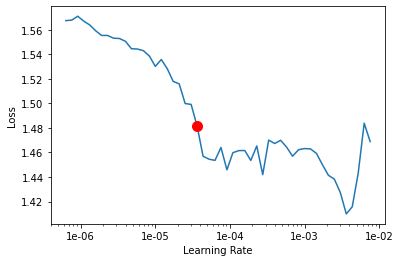

In [ ]:
learner.recorder.plot(skip_end=10, suggestion=True)

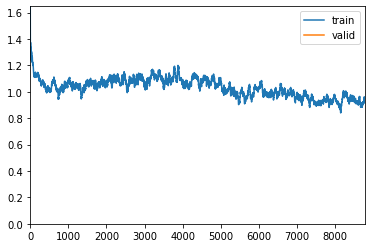

In [ ]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

In [ ]:
learner.save('first_cycle')

In [ ]:
seed_all(seed)
learner.load('first_cycle')

Learner(data=TextClasDataBunch;

Train: LabelList (140454 items)
x: TextList
[CLS] a series of es ##cap ##ades demonstrating the ada ##ge that what is good for the goose [SEP],[CLS] a series [SEP],[CLS] a [SEP],[CLS] series [SEP],[CLS] of es ##cap ##ades demonstrating the ada ##ge that what is good for the goose [SEP]
y: CategoryList
2,2,2,2,2
Path: .;

Valid: LabelList (15606 items)
x: TextList
[CLS] ' s as sorry [SEP],[CLS] romantic comedy and dog ##me 95 filmmaking may seem odd bed ##fell ##ows , but they turn out to be delightful ##ly compatible here [SEP],[CLS] of these days [SEP],[CLS] flinch from its un ##sett ##ling pro ##gno ##sis [SEP],[CLS] are clinical ##ly depressed [SEP]
y: CategoryList
2,4,2,2,1
Path: .;

Test: LabelList (66292 items)
x: TextList
[CLS] 1560 ##6 ##1 85 ##45 an intermittent ##ly pleasing but mostly routine effort . [SEP],[CLS] 1560 ##6 ##2 85 ##45 an intermittent ##ly pleasing but mostly routine effort [SEP],[CLS] 1560 ##6 ##3 85 ##45 an [SEP],[CLS] 1560 #

In [ ]:
learner.freeze_to(-2)

In [ ]:
lr = 1e-5

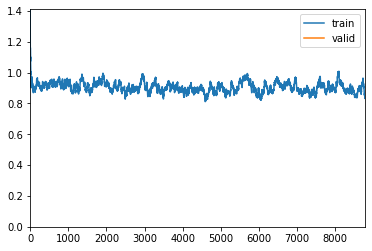

In [ ]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.save('second_cycle')

In [ ]:
seed_all(seed)
learner.load('second_cycle');

In [ ]:
learner.freeze_to(-3)

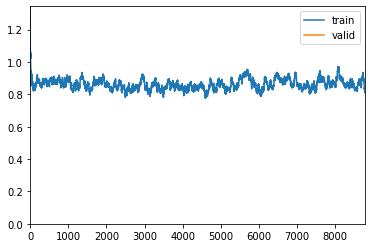

In [ ]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.save('third_cycle')

In [ ]:
seed_all(seed)
learner.load('third_cycle');

In [ ]:
learner.unfreeze()

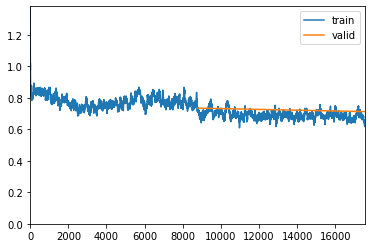

In [ ]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.predict('This movie is the worst one so far')

(Category tensor(0),
 tensor(0),
 tensor([8.7279e-01, 1.2167e-01, 4.9224e-03, 3.7885e-04, 2.3356e-04]))

#### Export Learner (model)

In [ ]:
# learner.export(file = '/content/drive/My Drive/LAB/kge_sentimtent_analysis/RoBERTa_model.pkl')
learner.export('export.pkl')
!mv ./export.pkl /content/drive/My\ Drive/LAB/kge_sentiment_analysis
!mv /content/drive/My\ Drive/LAB/kge_sentiment_analysis/export.pkl /content/drive/My\ Drive/LAB/kge_sentiment_analysis/BERT.pkl

In [ ]:
path = '/content/drive/My Drive/LAB/kge_sentiment_analysis'
export_learner = load_learner(path, file = 'BERT.pkl')

In [ ]:
export_learner.predict('This is the worst movie of 2020')

(Category tensor(0),
 tensor(0),
 tensor([8.9308e-01, 1.0117e-01, 5.0429e-03, 3.7354e-04, 3.3356e-04]))

#### Creating prediction

In [ ]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [ ]:
sample_submission = pd.read_csv(DATA_ROOT / 'sampleSubmission.csv')
sample_submission['Sentiment'] = np.argmax(test_preds, axis = 1)
sample_submission.to_csv('prediction.csv', index = False)

In [ ]:
test.head()

PhraseId  SentenceId                                             Phrase
0    156061        8545  An intermittently pleasing but mostly routine ...
1    156062        8545  An intermittently pleasing but mostly routine ...
2    156063        8545                                                 An
3    156064        8545  intermittently pleasing but mostly routine effort
4    156065        8545         intermittently pleasing but mostly routine

In [ ]:
sample_submission.head()

PhraseId  Sentiment
0    156061          2
1    156062          3
2    156063          2
3    156064          3
4    156065          2

In [ ]:
from IPython.display import HTML

def create_download_link(title = 'Download CSV file', filename = 'data.csv'):
    html = '<a href=(filename)->(title)</a>'
    html = html.format(title=title, filename=filename)
    return HTML(html)

create_download_link(filename='prediciton.csv')